In [17]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

from datetime import datetime
import time
import csv
sns.set_style("darkgrid")
results_2019 = pd.read_csv('./Runners_all_results_2019.csv', header = 0, encoding='latin-1', error_bad_lines=False)
results_2019['OfficialTime'] = results_2019['OfficialTime'].apply(lambda x: datetime.combine(datetime.min, datetime.strptime(x, '%H:%M:%S').time()) - datetime.min)
results_2019['OfficialTime'] = results_2019['OfficialTime'].apply(lambda x: x.total_seconds()/3600)
results_2019.head(2)

b'Skipping line 26144: expected 20 fields, saw 21\n'


,BibNumber,FullName,SortName,AgeOnRaceDay,Gender,City,StateAbbrev,StateName,Zip,CountryOfResAbbrev,CountryOfResName,CountryOfCtzAbbrev,CountryOfCtzName,OfficialTime,RankOverall,RankOverGender,RankOverDivision,EventGroup,SubGroupLabel,SubGroup
0,2,Lawrence Cherono,"Cherono, Lawrence",30,M,Eldoret,NaN,NaN,NaN,KEN,Kenya,KEN,Kenya,2.132500,1,1,1,Runners,NaN,NaN
1,6,Lelisa Desisa,"Desisa, Lelisa",29,M,Ambo,NaN,NaN,NaN,ETH,Ethiopia,ETH,Ethiopia,2.133056,2,2,2,Runners,NaN,NaN


In [18]:
results_2019.Gender[results_2019.Gender == 'M'] = 2
results_2019.Gender[results_2019.Gender == 'F'] = 0
results_2019.head(2)
points = results_2019[['AgeOnRaceDay', 'OfficialTime', 'Gender']]
points = points.to_numpy()
points

/home/micha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/micha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([[30, 2.1325, 2],
       [29, 2.1330555555555555, 2],
       [34, 2.1352777777777776, 2],
       ...,
       [53, 7.293055555555555, 2],
       [51, 7.4275, 0],
       [66, 7.73, 2]], dtype=object)

## Find clusters using [kMeans()](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [19]:
#klasa KMeans z sklearn, konstruktor przyjmuje liczbę klastrów i sposób inicjalizacji centroidów, random_state=1 za
#każdym razem te same punkty startowe
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, init='random', random_state=1)
kmeans.fit(points)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=4,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

In [20]:
#funkcja predict zwaraca etykiety klastru do jakiego został przypisany obiekt
clusters_id = kmeans.predict(points)

In [21]:
#pozycje centroidów
centroids = kmeans.cluster_centers_

Text(0.5, 0, 'Age')

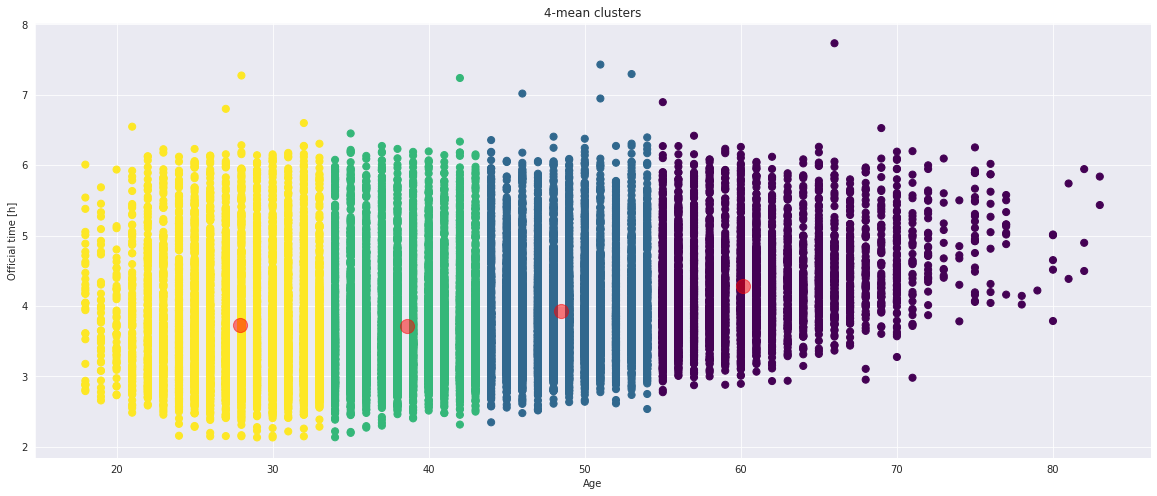

In [22]:
#każdy kolejny klaster dostaje inny kolor
plt.figure(figsize=(20,8))
plt.scatter(points[:, 0], points[:, 1], c=clusters_id, s=50, cmap='viridis')
#duże czerwone kropki to pozycje centroidów
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)
plt.title("4-mean clusters")
plt.ylabel("Official time [h]")
plt.xlabel("Age")

#klastrowanie w oparciu o wiek, oficjalny czas i płeć
#nie daje zadowalających wyników, klastry są przypadkowe z powodu pionowego podziału na lata

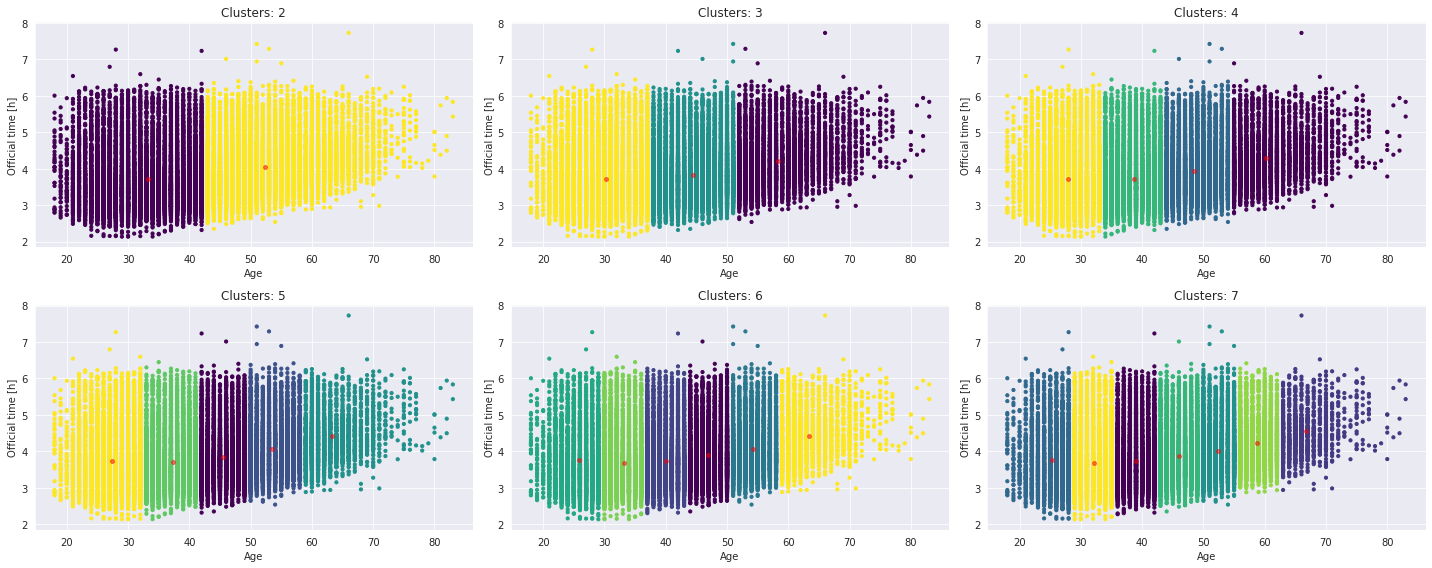

In [23]:
#jak będzie się zmieniać klasteryzacja gdy zadamy inną ilość klastrów
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
for k in [2,3,4,5,6,7]:
    kmeans_ = KMeans(n_clusters=k, init='random', random_state=1)
    kmeans_.fit(points)
    clusters_id_ = kmeans_.predict(points)
    plt.subplot("23"+str(k-1))
    plt.scatter(points[:, 0], points[:, 1], c=clusters_id_ , s=10, cmap='viridis')

    centroids_ = kmeans_.cluster_centers_
    plt.scatter(centroids_[:, 0], centroids_[:, 1], c='red', s=15, alpha=0.5)
    plt.title("Clusters: "+str(k))
    plt.ylabel("Official time [h]")
    plt.xlabel("Age")
plt.tight_layout()


#klastrowanie w oparciu o wiek, oficjalny czas i płeć (dla klastrów o rozmiarach od 2 do 7)
#nie daje zadowalających wyników, klastry są przypadkowe

## [DBSCAN()](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

Text(0.5, 0, 'Age')

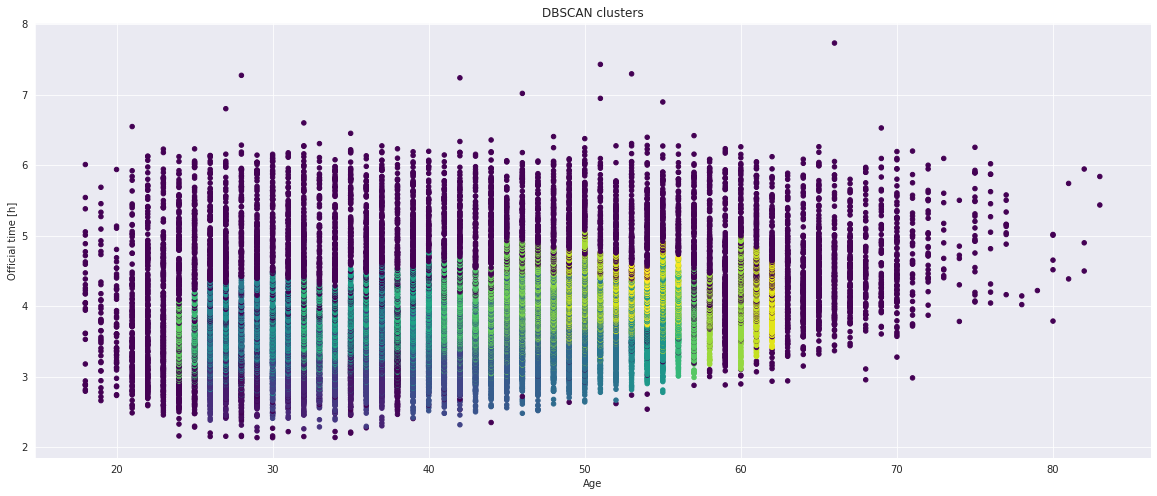

In [24]:
#funkcje jądrowe dokonują nieliniowej transformacji punktów do przestrzeni wielowymiarowej
#TRIKI JĄDROWE
#dbscan bierze pod uwagę gęstość punktów między sobą,
#znajduje pewne punkty rdzeniowe (żeby punkt był rdzeniowy musi być w koł niego odpowiednia liczba punktów)
#wszystkie punkty w okolicach jednego rdzenia i jego punkty brzegowe tworzą jeden klaster
#wyznaczamy odległości punktów względem siebie, a nie danego klastara
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.3694, min_samples=100, metric="euclidean").fit(points)
plt.figure(figsize=(20,8))
plt.scatter(points[:, 0], points[:, 1], c=db.labels_, s=20, cmap='viridis')
plt.title("DBSCAN clusters")
plt.ylabel("Official time [h]")
plt.xlabel("Age")

#dbscan jest dość wrażliwy na parametry jakie otrzymuje na starcie

#klastrowanie z wykorzystaniem funkcji jądrowych w oparciu o wiek, czas i płeć